In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:

import plotly.express as px
import datetime
from datetime import datetime
import calendar
from calendar import monthrange
from datetime import date


In [3]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [4]:
users = pd.read_csv('olist_customers_dataset.csv')

In [5]:
items = pd.read_csv('olist_order_items_dataset.csv')

In [6]:
orders = pd.read_csv('olist_orders_dataset.csv')

In [7]:
df = users.merge(orders, how = 'inner', on = 'customer_id')

Задача 1

Посмотрим, сколько пользователей совершили только одну покупку, убрав только что созданные заказы (они еще не оплачены, и их пока не учитываем).

In [8]:
(df.query('order_status != "created"') \
    .customer_unique_id.value_counts() >= 2).value_counts()
#93099 сделали только одну покупку

False    93096
True      2996
Name: customer_unique_id, dtype: int64

Задача 2

Посмотрим, сколько заказов мы не доставили в месяц по разным причинам (интересуют статусы canceled и unavailable, т.к. остальные либо пока в процессе, либо уже доставлены), и выведем визуализацию для наглядности

In [9]:
not_ordered = orders.query('order_status == "canceled" or order_status == "unavailable"')

In [10]:
not_ordered['month'] = not_ordered.order_purchase_timestamp.str.slice(stop=7)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
not_ordered.groupby(['month', 'order_status']) \
    .agg({'order_id': 'count'}).groupby('order_status').mean()
#Сколько заказов в месяц в среднем не доставляется по разным причинам

,order_id
order_status,
canceled,26.041667
unavailable,29.000000


In [12]:
vis = not_ordered.groupby(['month', 'order_status'], as_index=False).agg({'order_id': 'count'})
vis
#детализация по причинам (разбивка по месяцам)

,month,order_status,order_id
0,2016-09,canceled,2
1,2016-10,canceled,24
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,unavailable,10
5,2017-02,canceled,17
6,2017-02,unavailable,45
7,2017-03,canceled,33
8,2017-03,unavailable,32
9,2017-04,canceled,18


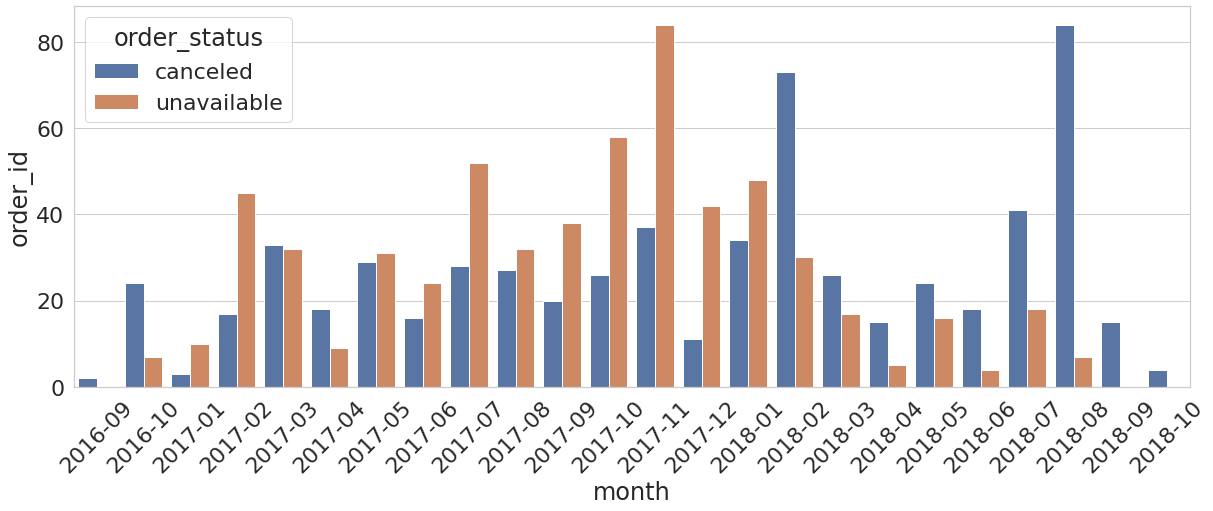

In [13]:
sns.barplot(x="month", y="order_id", hue="order_status", data=vis)
plt.xticks(rotation=45)
plt.show()
#визуализация детализации по причинам (разбивка по месяцам)

Задача 3

Определим по каждому товару, в какой день недели он покупается чаще всего

In [14]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [15]:
df['day'] = df.order_purchase_timestamp.dt.day_name()

In [16]:
full_data = df.merge(items, how = 'inner', on = 'order_id')

In [17]:
product_by_day = full_data.query('order_status != "unavailable" and order_status != "canceled"') \
    .groupby(['product_id', 'day'], as_index=False) \
    .order_purchase_timestamp.count() \
    .sort_values(by=['product_id', 'order_purchase_timestamp'], ascending=False) \
    .pivot(index='product_id', columns='day', values='order_purchase_timestamp') \
    .fillna(0)

In [18]:
product_by_day['Best_day'] = product_by_day.idxmax(axis=1)
product_by_day
#в какой день недели больше всего покупок товара - 3 задача

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Best_day
product_id,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sunday
00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tuesday
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Thursday
000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Friday
000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tuesday
...,...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,Saturday
fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Monday
fff9553ac224cec9d15d49f5a263411f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday


Задача 4

Посчитаем, сколько у каждого пользователя покупок в среднем в неделю (по месяцам)

In [19]:
full_data['order_purchase_data'] = pd.to_datetime(full_data.order_purchase_timestamp.astype(str).str.slice(stop=11))

In [20]:
full_data['order_purchase_month'] = full_data['order_purchase_data'].astype(str).str.slice(stop=7)

In [21]:
full_data['order_purchase_month'] = pd.to_datetime(full_data['order_purchase_month'])

In [22]:
task_4 = full_data.query('order_status != "unavailable" and order_status != "canceled"') \
    .groupby(['customer_unique_id', 'order_purchase_month'], as_index=False).order_id.count()

In [23]:
task_4['month'] = task_4.order_purchase_month.astype(str).str.slice(start=5, stop=7)

In [24]:
task_4['month'] = task_4.month.astype(int)

In [25]:
task_4['days'] = task_4.order_purchase_month.dt.daysinmonth

In [26]:
task_4['week'] = task_4['days'] / 7

In [27]:
task_4['number_of_purchases_per_week'] = task_4['order_id'] / task_4['week']
#посчитали среднее количество покупок в неделю по месяцам для каждого из пользователей
task_4

,customer_unique_id,order_purchase_month,order_id,month,days,week,number_of_purchases_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,5,31,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,5,31,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,3,31,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,10,31,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,11,30,4.285714,0.233333
...,...,...,...,...,...,...,...
96856,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,2,6,30,4.285714,0.466667
96857,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1,12,31,4.428571,0.225806
96858,ffff371b4d645b6ecea244b27531430a,2017-02-01,1,2,28,4.000000,0.250000
96859,ffff5962728ec6157033ef9805bacc48,2018-05-01,1,5,31,4.428571,0.225806


Задача 5

Напишем функцию, позволяющую делить пользователей на когорты по давности совершения покупки, и вычислять на эти когорт показатель возврата. Функция будет принимать на вход 3 переменные: разницу дней с первой до текущей транзакции, месяц первой покупки (т.к. делим по месяцам), и количество заказов у пользователя. Для начала подготовим данные.

In [28]:
task_5 = full_data \
    .query('order_status != "unavailable" and order_status != "canceled"') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({"order_purchase_data": "min", "order_id": "count"}) \
    .rename(columns={'order_purchase_data': 'first_purchase_data', 'order_id': 'count_orders'})

In [29]:
task_5["first_purchase_month"] = task_5['first_purchase_data'].dt.strftime('%Y-%m')

In [30]:
task_5_final = pd.merge(full_data, task_5, how = "left", on = "customer_unique_id")

In [31]:
#расчитаем количество дней с первой транзакции
task_5_final["delta_days"] = task_5_final['order_purchase_data'] - task_5_final['first_purchase_data']
task_5_final["delta_days"] = task_5_final["delta_days"].apply(lambda x: x.days)

In [32]:
def cohort_analysis(delta_days, first_purchase_month, count_orders):
    data_groupby_user_final = pd.DataFrame()
    data_groupby_user_final["delta_days"] = delta_days
    data_groupby_user_final["first_purchase_month"] = first_purchase_month
    data_groupby_user_final["count_orders"] = count_orders
    # Выделяем когорты
    cut_labels_days = [x for x in range (30, 1230, 30)]
    cut_bins_days = [x for x in range (0, 1230, 30)]
    data_groupby_user_final["cohort_days"] = pd.cut(data_groupby_user_final["delta_days"], 
                                                    bins = pd.to_timedelta([x for x in range (0, 1230, 30)]), 
                                                    labels=cut_labels_days, right = True)
    #Заменяем нулевые значения в категориальных данных
    data_groupby_user_final["cohort_days"] = data_groupby_user_final["cohort_days"].cat.add_categories([0])
    data_groupby_user_final["cohort_days"].fillna(0, inplace=True)
    data_groupby_user_final["cohort_days"] = data_groupby_user_final["cohort_days"].astype(int)
    #Построим сводную таблицу
    data_pivot = data_groupby_user_final.pivot_table(values=["count_orders"], 
                                                     index=["first_purchase_month"], columns=["cohort_days"], 
                                                     aggfunc=np.sum, fill_value = 0)
    #Та же самая таблица, но не с абсолютными значениями, а с показателем retention
    cog = data_pivot.iloc[:,0:].div((data_pivot.iloc[:,0]), axis=0)
    return cog

In [33]:
user_retention = cohort_analysis(task_5_final['delta_days'], 
                                 task_5_final['first_purchase_month'], task_5_final['count_orders'])
user_retention

count_orders                                          \
cohort_days                   0         30        60        90        120   
first_purchase_month                                                        
2016-09                       1.0  0.000000  0.000000  0.000000  0.000000   
2016-10                       1.0  0.005484  0.000000  0.000000  0.000000   
2016-12                       1.0  1.000000  0.000000  0.000000  0.000000   
2017-01                       1.0  0.035097  0.002160  0.000000  0.007019   
2017-02                       1.0  0.008598  0.003738  0.002243  0.006355   
2017-03                       1.0  0.016266  0.004243  0.012966  0.007308   
2017-04                       1.0  0.015775  0.006761  0.004507  0.000563   
2017-05                       1.0  0.024517  0.015366  0.024344  0.007942   
2017-06                       1.0  0.009015  0.018439  0.020897  0.006146   
2017-07                       1.0  0.014799  0.007098  0.005134  0.005285   
2017-08                       1.0  0.016294  0.014637  0.007871  0.006352   
2017-09                       1.0  0.022138  0.011943  0.015875  0.014710   
2017-10                       1.0  0.017751  0.012537  0.000869  0.009186   
2017-11                       1.0  0.022160  0.008535  0.007047  0.003524   
2017-12                       1.0  0.009475  0.003909  0.010423  0.009238   
2018-01                       1.0  0.011667  0.010710  0.009404  0.005660   
2018-02                       1.0  0.011951  0.013958  0.015005  0.012562   
2018-03                       1.0  0.018115  0.007088  0.004026  0.003851   
2018-04                       1.0  0.017257  0.012832  0.007080  0.004779   
2018-05                       1.0  0.020377  0.007213  0.009918  0.000721   
2018-06                       1.0  0.009909  0.006884  0.003442  0.000000   
2018-07                       1.0  0.014365  0.001383  0.000000  0.000000   
2018-08                       1.0  0.040333  0.000000  0.000000  0.000000   

                                                                        ...  \
cohort_days                150       180       210       240       270  ...   
first_purchase_month                                                    ...   
2016-09               0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2016-10               0.000000  0.000000  0.003656  0.000000  0.000000  ...   
2016-12               0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2017-01               0.001080  0.001080  0.007559  0.006479  0.000000  ...   
2017-02               0.002991  0.002991  0.004486  0.000748  0.002243  ...   
2017-03               0.001650  0.001179  0.006129  0.002829  0.007072  ...   
2017-04               0.007606  0.007324  0.025352  0.011831  0.003380  ...   
2017-05               0.008633  0.018128  0.007769  0.001381  0.019682  ...   
2017-06               0.011473  0.009834  0.007990  0.002868  0.001434  ...   
2017-07               0.011930  0.003775  0.002869  0.002567  0.006947  ...   
2017-08               0.006904  0.009390  0.007457  0.020022  0.005800  ...   
2017-09               0.010778  0.013254  0.005243  0.002767  0.004661  ...   
2017-10               0.010551  0.002483  0.014896  0.005834  0.008937  ...   
2017-11               0.003367  0.004620  0.003054  0.003445  0.000783  ...   
2017-12               0.003553  0.003909  0.001658  0.003079  0.002369  ...   
2018-01               0.002525  0.005050  0.003396  0.001306  0.000000  ...   
2018-02               0.003751  0.003315  0.001047  0.000000  0.000000  ...   
2018-03               0.002363  0.000525  0.000000  0.000000  0.000000  ...   
2018-04               0.001150  0.000000  0.000000  0.000000  0.000000  ...   
2018-05               0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2018-06               0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2018-07               0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2018-08               0.000000  0.000000  0

In [34]:
coh_style = (user_retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
coh_style

In [35]:
(cohort_analysis(task_5_final['delta_days'], task_5_final['first_purchase_month'], task_5_final['count_orders'])) \
    .iloc[:,3].idxmax()
#нашли когорту с максимальным процентом возврата на 3 месяц - для задачи 5

'2017-05'

Задача 6

Построим 27 RFM-кластеров для пользователей:
Метрику R делим на 3 кластера: "давние", "относительно недавние" и "недавние".
Метрику F делим на 3 кластера: "разовые", "редкие" и "частые".
Метрику M делим на кластеры по чекам: "низкий", "средний", "высокий".

В результате получим кластеры вида, например, 311 - этот номер будет присвоен пользователю, который недавно совершил разовую покупку с низким чеком.

In [36]:
task_6 = full_data.query('order_status != "canceled" or order_status != "unavailable"')

Проверим, есть ли выбросы в данных. Нас интересуют поля order_purchase_data, order_id и price - по ним будем проводить анализ

In [37]:
(task_6.order_purchase_data - pd.Timestamp('today')).astype(int).describe()

count    1.126500e+05
mean    -1.367935e+17
std      1.323170e+16
min     -1.785568e+17
25%     -1.462432e+17
50%     -1.351840e+17
75%     -1.261120e+17
max     -1.155712e+17
Name: order_purchase_data, dtype: float64

По order_purchase_data выбросов нет

In [38]:
task_6.groupby(['customer_unique_id']).agg({'order_id': 'count'}).order_id.describe()

count    95420.00000
mean         1.18057
std          0.62145
min          1.00000
25%          1.00000
50%          1.00000
75%          1.00000
max         24.00000
Name: order_id, dtype: float64

75 квартиль равен 1, в то время как масимальное значение - 24, это выброс по order_id

In [39]:
task_6.price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

75 квартиль равен 134.900000, в то время как масимальное значение - 6735.000000, это выброс по price

Построим R-кластеры для пользователей. Для этого посмотрим, за какой период у нас есть данные

In [40]:
task_6.describe(include='datetime')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence thi

,order_purchase_timestamp,order_purchase_data,order_purchase_month
count,112650,112650,112650
unique,98112,616,24
top,2017-07-16 18:19:25,2017-11-24 00:00:00,2017-11-01 00:00:00
freq,21,1366,8665
first,2016-09-04 21:15:19,2016-09-04 00:00:00,2016-09-01 00:00:00
last,2018-09-03 09:06:57,2018-09-03 00:00:00,2018-09-01 00:00:00


Данные есть за 2 года - с сентября 2016 по сентябрь 2018. Разделим на кластеры по давности, посчитаем от сегодняшнего дня:
1 кластер "Давние" - совершившие покупку с сентября 2016 по апрель 2017;
2 кластер "Относительно недавние" - совершившие покупку с мая 2017 по декабрь 2017;
3 кластер "Недавние" - совершившие покупку с января по сентябрь 2018;

In [41]:
pd.Timestamp('today')

Timestamp('2022-05-02 15:06:32.826405')

In [42]:
task_6['delta_days'] = (task_6.order_purchase_data - pd.Timestamp('today')).astype(int)

In [43]:
task_6['R'] = pd.cut(task_6.delta_days, 
                                 bins=3, 
                                 labels=['1', '2', '3'])
#Используем этот способ, так как выбросов в данных нет

In [44]:
task_6.delta_days

0        -156611192859120000
1        -135788792859120000
2        -124815992859120000
3        -130604792859120000
4        -118681592859120000
                 ...        
112645   -128444792859120000
112646   -128703992859120000
112647   -128358392859120000
112648   -141836792859120000
112649   -137862392859120000
Name: delta_days, Length: 112650, dtype: int64

In [45]:
pd.to_timedelta(task_6.groupby('R', as_index=False).agg({'delta_days': 'mean'}).delta_days)
#нашли среднее значение каждого кластера по метрике R

0   -1880 days +14:21:10.962240896
1   -1687 days +17:23:47.438442976
2   -1466 days +20:00:55.965156416
Name: delta_days, dtype: timedelta64[ns]

Теперь построим F-кластер с разовыми, редкими и частыми покупками. В целом, большая часть пользователей совершила только одну покупку за 24 месяца:
разовые покупки - все пользователи, которые совершили покупку 1 раз за период;
редкие - те, кто совершил покупку два или три раза;
частые - остальные

In [46]:
#используем показатель R для определения частоты покупки
task_6_final = task_6.groupby(['customer_unique_id', 'R']) \
    .agg({'order_id': 'count'}).groupby(['customer_unique_id']).order_id.sum()

In [47]:
frequency = []

In [48]:
for i in task_6_final:
    if i == 1:
        frequency.append(1)
    elif i in (2,3):
        frequency.append(2)
    else:
        frequency.append(3)

In [49]:
task_6_final = task_6_final.to_frame()

In [50]:
task_6_final['F'] = frequency

In [51]:
task_6_final

,order_id,F
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1
0000f46a3911fa3c0805444483337064,1,1
0000f6ccb0745a6a4b88665a16c9f078,1,1
0004aac84e0df4da2b147fca70cf8255,1,1
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,2
fffea47cd6d3cc0a88bd621562a9d061,1,1
ffff371b4d645b6ecea244b27531430a,1,1


In [52]:
task_6_final.groupby('F').order_id.mean()
#нашли среднее значение каждого кластера по метрике F

F
1    1.000000
2    2.156730
3    5.071607
Name: order_id, dtype: float64

In [53]:
task_6_final = task_6_final.reset_index().drop('order_id', 1)

In [54]:
task_6 = pd.merge(task_6, task_6_final, how = "left", on = "customer_unique_id")

Выделим кластеры по сумме покупок = M: "низкий", "средний" и "высокий" чек

In [55]:
task_6_money = task_6.groupby(['customer_unique_id', 'order_id'], as_index=False). price.sum()

In [56]:
task_6_money['M'] = pd.qcut(task_6_money.price, 
                                 q=3, 
                                 labels=['1', '2', '3'])
#Выбрали этот способ, т.к. в данных присутствуют выбросы

In [57]:
task_6_money.groupby('M', as_index=False).price.mean()
#нашли среднее значение каждого кластера по метрике М

,M,price
0,1,34.376150
1,2,87.486553
2,3,293.317636


In [58]:
task_6 = pd.merge(task_6, task_6_money, how = "left", on = "customer_unique_id")

In [59]:
task_6['RFM'] = task_6.R.astype('str')+task_6.F.astype('str')+task_6.M.astype('str')

In [60]:
rmean=[]

In [61]:
for i in task_6.R:
    if i == '1':
        rmean.append('-1788 days +08:54:45.310471168')
    elif i == '2':
        rmean.append('-1595 days +11:57:21.786672656')
    else:
        rmean.append('-1374 days +14:34:30.313384736')

In [62]:
task_6['rmean'] = rmean

In [63]:
fmean=[]

In [64]:
for i in task_6.F:
    if i == 1:
        fmean.append('1.000000')
    elif i == 2:
        fmean.append('2.156730')
    else:
        fmean.append('5.071607')

In [65]:
task_6['fmean'] = fmean

In [66]:
mmean=[]

In [67]:
for i in task_6.M:
    if i == '1':
        mmean.append('34.376150')
    elif i == '2':
        mmean.append('87.486553')
    else:
        mmean.append('293.317636')

In [68]:
task_6['mmean'] = mmean

In [69]:
task_6.groupby('RFM', as_index=False).agg({'rmean': 'min', 'fmean': 'min', 'mmean': 'min'})

,RFM,rmean,fmean,mmean
0,111,-1788 days +08:54:45.310471168,1.000000,34.376150
1,112,-1788 days +08:54:45.310471168,1.000000,87.486553
2,113,-1788 days +08:54:45.310471168,1.000000,293.317636
3,121,-1788 days +08:54:45.310471168,2.156730,34.376150
4,122,-1788 days +08:54:45.310471168,2.156730,87.486553
5,123,-1788 days +08:54:45.310471168,2.156730,293.317636
6,131,-1788 days +08:54:45.310471168,5.071607,34.376150
7,132,-1788 days +08:54:45.310471168,5.071607,87.486553
8,133,-1788 days +08:54:45.310471168,5.071607,293.317636
9,211,-1595 days +11:57:21.786672656,1.000000,34.376150
